## Rover Project Test Notebook

In [36]:
%matplotlib inline
import cv2 
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc 
import glob 
import imageio
imageio.plugins.ffmpeg.download()


## Quick Look at the Data

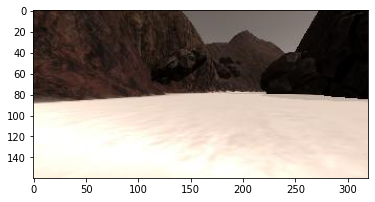

In [3]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Displaying random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data


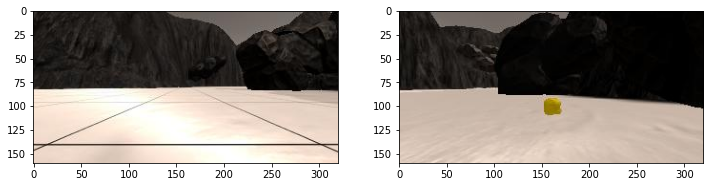

In [4]:
#Example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform


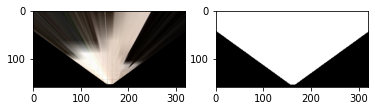

In [38]:
#  A perspective transformed image have to be
# generated to have a flattened top-down view of the field of view to differentiate between navigable and
# non-navigable terrain. This function creates the perepective transformation

#The function takes the image, coordinates in the source image, and coordinates in the output image
def perspect_transform(img, src, dst):
    #Then it generates a transformation matrix and store it at M
    M = cv2.getPerspectiveTransform(src, dst)
    #Then it uses the transformation matrix with the image to apply the perspective transformation to the image
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    #Then we create a mask which will have a values of 1s for navigable pixels and 0s for non-navigable pixels
    mask = cv2.warpPerspective(np.ones_like(img[:,:,0]),M, (img.shape[1], img.shape[0]))
    #Then return both the mask and the transformed image
    return warped , mask

warped, mask = perspect_transform(grid_img, source, destination)
plt.figure()
plt.subplot(121)
plt.imshow(warped)
plt.subplot(122)
plt.imshow(mask,cmap='gray')


## Color Thresholding

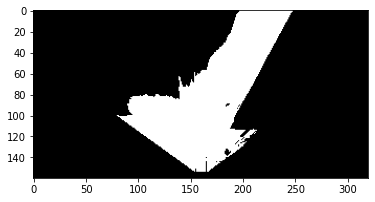

In [7]:
#This function is used to detect and identify pixels that exceeds a given threshold.
#An image and a desired threshold is given to the function.

def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # uses numpy to create a 0 initialized array where the detected element will be marked on
    color_select = np.zeros_like(img[:,:,0])
    # Then it will iterate on the three channels of the given image comparing it to the threshold
    # If the given threshold is met, then it will be marked on the color_select which will be returned later
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    color_select[above_thresh] = 1
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')


## Coordinate Transformations


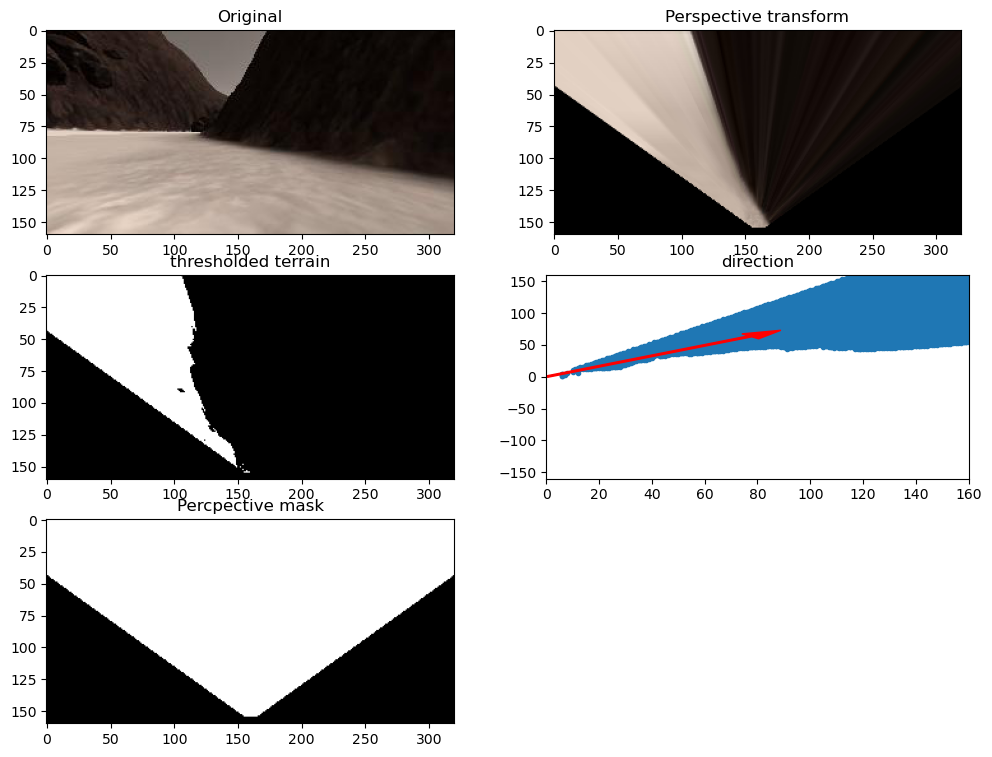

In [8]:
# Both the generated image and actual rover coordinates are different, this why we need to translate the image coordinates to the rover coordinates using this function
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Subtracting the y coordinates of the image from the rovers y position then invert it
    # Subtracting half of the x coordinates of the image from the rovers x position then invert it  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float32)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float32)
    #Then return the float values of both x and y coordinates.
    return x_pixel, y_pixel


# Having a cartesian coordinate may be useful for a specific case but having a polar coordinate will help a lot. 
#This why this function converts from cartesian coordinates to polar coordinates.
def to_polar_coords(x_pixel, y_pixel):
    # It takes x and y coordinates
    #Then calculates the distance by taking the square root of the squared coordinates 
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # It takes the arctan of the coordinates to calculate the angles
    angles = np.arctan2(y_pixel, x_pixel)
    #Then it returns both destinations and angles
    return dist, angles

# The rotate_pix function is used to map the rover space to the world space
#The function takes x,y and yaw axis as a parameters
def rotate_pix(xpix, ypix, yaw):
    # Then converts the yaw into radiant
    yaw_rad = yaw * np.pi / 180
    #Then rotates the x and y coordinates by using the converted yaw radiant
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Then it returns the rotated coordinates  
    return xpix_rotated, ypix_rotated

#The following function applies both translation and scaling on any given coordinates
#X and y coordinates, the amount of translation in x and y coordinates, and the scaling factor is a parameters of the function
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # The scaling is a division/multiplication operation, and the translation is plus/minus operations
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Then it returns the translated and scaled coordinates.  
    return xpix_translated, ypix_translated


# The pix_to_world function is a function that applies different geometric transformations to output the final world map image. 
#It also ties the previous functions together
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # First it rotates the x and y coordinates
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Then it translates and scale them using the given value
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Then at the end it clip the unwanted values to only have the wanted values
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # It returns the final x and y coordinates for the map image
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped, mask_trrain = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(321)
plt.imshow(image)
plt.gca().set_title('Original')
plt.subplot(322)
plt.imshow(warped)
plt.gca().set_title('Perspective transform')
plt.subplot(323)
plt.imshow(threshed, cmap='gray')
plt.gca().set_title('thresholded terrain')
plt.subplot(324)
plt.gca().set_title('direction')
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
plt.subplot(325)
plt.gca().set_title('Percpective mask')
plt.imshow(mask,cmap='gray')



# Find Rocks Function

Text(0.5, 1.0, 'thresholded rock image')

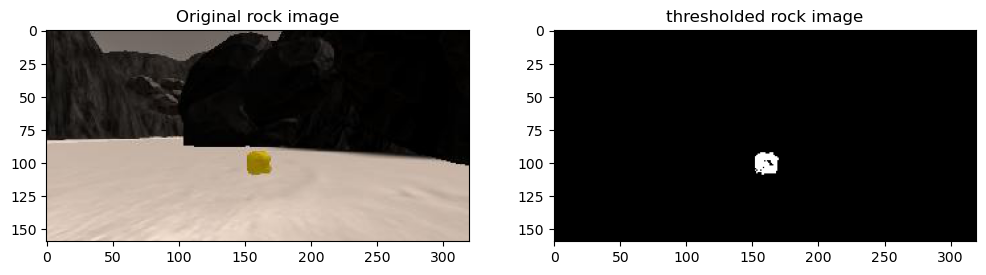

In [9]:
#The find_rocks function is similar to the color_tresh function as it uses thresholding to identify the rocks
#but with minor modifications
#It takes the image and the wanted threshold
def find_rocks(img, thresh = (110,110,50)):
    #It compares the image three channels to the given threshold and store the values to rock_pixels
    rock_pixels = ((img[:,:,0]>thresh[0])\
                  &(img[:,:,1]>thresh[1])\
                  &(img[:,:,2]<thresh[2]))
    #A zero array is generated
    colored_pixels = np.zeros_like(img[:,:,0])
    #The identified pixels that met the conditions will be used as an index for the zero array generated
    #and every found rock will be equal to 1
    colored_pixels[rock_pixels] = 1
    #The zero array is returned
    return colored_pixels

rockThesholded = find_rocks(rock_img)
# Do some plotting
fig = plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(rock_img)
plt.gca().set_title('Original rock image')
plt.subplot(122)
plt.imshow(rockThesholded, cmap='gray')
plt.gca().set_title('thresholded rock image')

## Reading saved data and ground truth map of the world

In [10]:
# Importing pandas and read in csv file as a dataframe
import pandas as pd
df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Creating list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(float)

# Creating a class to be the data container

class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
data = Databucket()


## Processing Stored Images

In [34]:

# This function is the function that tie the previous functions together to create a better perception of the
#world and achieve the objectives we want

def perception_step(img):
    
    
    #Define the dst_size which is the destination size
    dst_size = 10
    #Define bottom_offset which is just an offset the gives us a buffer by moving the position 5 units to the front
    bottom_offset = 5
    image = Rover.img
    #Defining the image, source, and destinations points for the perspective transformation
    source = np.float32([[14, 140], [301 ,140],[200,96], [118, 96]])
    destination = np.float32([[image.shape[1]/2 -dst_size, image.shape[0] - bottom_offset],
    [image.shape[1]/2 + dst_size,
    image.shape[0] - bottom_offset],
    [image.shape[1]/2 + dst_size,
    image.shape[0] - 2*dst_size - bottom_offset],
    [image.shape[1]/2 - dst_size,
    image.shape[0] - 2*dst_size - bottom_offset],
    ])

    #generate a perspective transformation and return the transformed image and the mask
    warped , mask = perspect_transform(img, source, destination)
    
    #Then it will apply color thresholding to identify navigable terrain, non-navigable terrain and rocks
    threshed = color_thresh(warped)
    #Then it will generate obstacle maps in obs_map by multiplying the mask with threshold -1 
    #so we get only the things in the field of view
    obs_map = np.absolute(np.float32(threshed)-1)*mask
    #Using the threshold and the obstacle map we modify the vision image for both the obstacles and the navigable terrain
    Rover.vision_image[:,:,2] = threshed *255
    Rover.vision_image[:,:,0] = obs_map *255
    #convert the image coordinates to rover coordinates
    xpix, ypix = rover_coords(threshed)
    dist, angles = to_polar_coords(xpix, ypix)
    mean_dir = np.mean(angles)
    # define variables related to the scale and world size which will be used for the next step
    world_size = data.worldmap.shape[0]
    scale =2* dst_size
    #convert the rover coordinates to world coordinates for both the obstacles and the walkable world 
    x_world , y_world = pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale)
    obsxpix, obsypix = rover_coords(obs_map)
    obs_x_world , obs_y_world = pix_to_world(obsxpix, obsypix, xpos, ypos, yaw, world_size, scale)
    
    if(Rover.pitch< 1.6):
        if(Rover.roll<5):
            Rover.worldmap[y_world,x_world,2]+=10
            Rover.worldmap[obs_y_world,obs_x_world,0]+=1

    # An updated rover worldmap is generated to be on the right 
    # prevents the rotation unless a certain pitch and roll is satisfied
    
    #The navigable terrain becomes blue given the world coordinates
    #The obstacles become red given the obstacles coordinates
    
    #Then the world is converted from rover coordinates to polar coordinates
    dist, angles = to_polar_coords(xpix,ypix)
    Rover.nav_angles = angles
    
    
    
    # The find_rocks function is used to find the rocks
    #If rocks are identified, then it will convert the rock position to rover coordinates then to world
    #coordinates then to polar coordinate
    #Then color the rock with white on the map
    rock_map = find_rocks(warped,(110,110,50))
    if rock_map.any():
     rock_xpix , rock_ypix = rover_coords(rock_map)
     rock_xpix_world , rock_ypix_world= pix_to_world(rock_xpix, rock_ypix, Rover.pos[0],
     Rover.pos[1], Rover.yaw, world_size, scale)
     rock_dist,rock_ang = to_polar_coords(rock_xpix,rock_ypix)
     rock_idx = np.argmin(rock_dist)
     rock_xcen = rock_xpix_world[rock_idx]
     rock_ycen = rock_ypix_world[rock_idx]
     Rover.worldmap[rock_ycen, rock_xcen,1] = 255
     Rover.vision_image[:,:,1] = rock_map *255
    else:
        Rover.vision_image[:,:,1]=0

    
    # Making a mosaic image
        # First creating a blank image 
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # populating regions of the image with various output
        # putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # creating more images to add to the mosaic, first a warped image
        # Adding the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

### Creating Video 

In [30]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))